# Fermi Hubbard Ground State Energy Estimation with Quantum Circuits

## Single Band

The Fermi-Hubbard model is often used to predict the behavior of the electrons of proposed superconductors.  It has the advantage of being simply stated while describing a variety of phenomena relating to the phases of real-world materials such as the transition between superconducting and Mott insulator phases.  In order to understand the behavior of the Fermi-Hubbard model at high temperatures, it is first critical to understand the phase diagram of the Fermi-Hubbard model at absolute zero (with no heat-bath present).  To achieve this, one must understand the ground state energy of the model with various filling coefficients.  In this notebook, we will show the necessary steps to perform this analysis on a quantum computer.

The most basic form of the Fermi-Hubbard model with a single band can be represented through the following equation:

\begin{equation}
H = -\sum_{( i,j )}\sum_{\sigma \in \{ \uparrow, \downarrow \}} t_{i,j} c^{\dagger}_{i,\sigma} c_{j,\sigma} 
  + U \sum c^{\dagger}_{i,\uparrow} c^{\dagger}_{i,\downarrow} c_{i,\downarrow} c_{i, \uparrow}
\end{equation}

which can be equivavlently written as 

\begin{equation}
H = -\sum_{( i,j )}\sum_{\sigma \in \{ \uparrow, \downarrow \}} t_{i,j} c^{\dagger}_{i,\sigma} c_{j,\sigma} 
  + U \sum n_{i, \uparrow} n_{i, \downarrow}
\end{equation}

where $c^{\dagger}_{i, \uparrow}$ is the fermionic creation operator on site $i$ with a spin $\uparrow$ and $c_{i, \uparrow}$ is the fermionic annihilation operator on site $i$ with a spin $\uparrow$.  The number operator on site $i$ with spin $\uparrow$ is given by $n_{i, \uparrow} = c^{\dagger}_{i, \uparrow} c_{i, \uparrow}$.  We will assume that the interactions are occurring on a 2-d square lattice, defining the site connectivity $(i,j)$. The coefficients $t_{i,j}$ represent the affinity for tunnelling between two orbitals at sites $i$ and $j$ and the coefficient $U$ represents the strength of the Coulomb interaction between electrons on the same orbital.

There are 3 steps to estimate the ground state energy of this Hamiltonian:

1. Prepare an initial state believed to have non-vanishing overlap with the actual ground state of the input Hamiltonian.  This is believed to be reasonably achieved by first using the classical Hartree-Fock Approximation to prepare a product state with low energy and applying local unitary rotations to the $|0...0\rangle$ state.

2. Perform Ground State Energy Estimation to determine the configuration of low energy states of the input Hamiltonian. The Hamiltonian must first be transformed into a Hamiltonian represented in the Pauli Basis by applying a transformation such as either the Jordan-Wigner Transformation or the Bravyi-Kitaev Transformation.

3. Measure autocorrelation operators $\frac{1}{2} \langle \Delta_{i,j} + \Delta_{i,j}^{\dagger}\rangle$ where $\Delta_{i,j} = \langle c_{i+}c_{j-} - c_{i-}c_{j+} \rangle$.  This can be achieved by applying the same transformation used in 2. and applying that Pauli operator as a rotation to translate the observable into the Pauli basis.

This procedure can be repeated for input states with various electron fillings to compute the phase diagram for the system.



In [20]:
import time

import openfermion as of

import numpy as np

from networkx import get_node_attributes, draw, draw_networkx_edge_labels

from qca.utils.utils import EstimateMetaData
from qca.utils.algo_utils import gsee_resource_estimation
from qca.utils.hamiltonian_utils import (generate_two_orbital_nx, nx_to_two_orbital_hamiltonian,
     generate_three_orbital_nx, nx_to_three_orbital_hamiltonian)

In [21]:
#Generating a 20x20 Fermi Hubbard model with a single band.  The ratio between Tunneling and Coulomb parameters can be swept to search for the appropriate mean electron filling.
n = 20
####START UNCOMMENT FOR TESTING
n = 2
####END UNCOMMENT FOR TESTING
tunneling = 1
coulomb = 8
ham_one_band = of.fermi_hubbard(n, n, tunneling=tunneling, coulomb=coulomb, periodic=False) #returns an aperiodic fermionic hamiltonian

Now that we have the Hamiltonian generated, we need to generate an initial state with non-vanishing overlap with the ground state (or the low energy subspace).  This can reasonably be achieved by using mean field methods like Hartree-Fock.  This is an advantageous approach since Hartree-Fock will generate a product state, which should be easily prepared using local operations.  We are currently looking for good implementations for the Fermi-Hubbard model, so we do not currently have this portion incorporated into this notebook, but it will be implemented in the coming weeks.

In [3]:
#TODO: Incorporate Hartree-Fock into this section to prepare the initial state for QPE for GSEE.
#This should provide a low depth initialization circuit relative to the depth of the QPE, while giving access to a low-energy subspace

Once the initial state has been prepared, we can now perform Quantum Phase Estimation to estimate the ground state energy.  Currently we are using a short evolution time and a second order trotterization with a single step.  We use scaling arguments to determine the final resources since generating the full circuit for a large number of trotter steps with many bits of precision is quite costly.  The circuit depth scales linearly with the number of trotter steps and exponentially base 2 for the number of bits of precision.  This means that all of the resource estimates will be rather large.  It should be noted that more recently, there has been an implementation released in pyLIQTR for using Quantum Phase Estimation with Quantum Signal Processing as a sub-process.  Whether this can yield an improvement in resource requirements has yet to be explored. We would like to find results with a precision on the order of $10^{-5}$, so we are using 16 bits of precision.

In [4]:
trotter_order_one_band = 2
trotter_steps_one_band = 1 #Using one trotter step for a strict lower bound with this method

#this scales the circuit depth proportional to 2 ^ bits_precision
bits_precision_one_band = 16

E_min_one_band = -len(ham_one_band.terms)
E_max_one_band = 0
one_band_omega = E_max_one_band-E_min_one_band
t_one_band = 2*np.pi/one_band_omega
one_band_phase_offset = E_max_one_band*t_one_band

args_one_band = {
    'trotterize' : True,
    'mol_ham'    : ham_one_band,
    'ev_time'    : t_one_band,
    'trot_ord'   : trotter_order_one_band,
    'trot_num'   : 1 #handling adjustment in resource estimate to save time - scales circuit depth linearly.
}


init_state_one_band = [0] * n * n * 2 #TODO: use Fock state from Hartree-Fock as initial state

one_band_metadata = EstimateMetaData(
    id=2000,
    name='FermiHubbard_One_Band',
    category='scientific',
    size=f'{n}x{n}',
    task='Ground State Energy Estimation',
    implementations=f'GSEE, evolution_time={t_one_band}, bits_precision={bits_precision_one_band}, trotter_order={trotter_order_one_band}',
)

Now we need to convert the GSEE circuit to Clifford + T and write the data to a file

In [5]:
print('Estimating one_band')
t0 = time.perf_counter()
gsee_resource_estimation(
    outdir='GSE/FermiHubbard/',
    numsteps=trotter_steps_one_band,
    gsee_args=args_one_band,
    init_state=init_state_one_band,
    precision_order=1,
    bits_precision=bits_precision_one_band,
    phase_offset=one_band_phase_offset,
    circuit_name='one_band',
    metadata=one_band_metadata,
    write_circuits=True
)
t1 = time.perf_counter()
print(f'Time to estimate one_band: {t1-t0}')

Estimating one_band
Time to generate circuit for GSEE: 8.066699956543744e-05 seconds
   Time to decompose high level <class 'cirq.ops.common_gates.HPowGate circuit: 0.00020158299594186246 seconds 
   Time to transform decomposed <class 'cirq.ops.common_gates.HPowGate circuit to Clifford+T: 0.0004812920233234763 seconds
   Time to decompose high level <class 'cirq.ops.identity.IdentityGate circuit: 2.72089964710176e-05 seconds 
   Time to transform decomposed <class 'cirq.ops.identity.IdentityGate circuit to Clifford+T: 9.29099041968584e-06 seconds
   Time to decompose high level <class 'pyLIQTR.PhaseEstimation.pe_gates.PhaseOffset circuit: 0.00012083398178219795 seconds 
   Time to transform decomposed <class 'pyLIQTR.PhaseEstimation.pe_gates.PhaseOffset circuit to Clifford+T: 0.00011850000009872019 seconds
   Time to decompose high level <class 'pyLIQTR.PhaseEstimation.pe_gates.Trotter_Unitary circuit: 0.049456957989605144 seconds 
   Time to transform decomposed <class 'pyLIQTR.Phase

After Ground State Energy Estimation has been performed, we need to measure the autocorrelation, $\frac{1}{2} \langle \Delta_{i,j} + \Delta_{i,j}^{\dagger}\rangle$ where $\Delta_{i,j} = \langle c_{i+}c_{j-} - c_{i-}c_{j+} \rangle$.  For the case where $i = j = 0$ is in the middle of the lattice, one can rotate into the Pauli basis using the following transformation.  We will label the qubit representing site $i+$ as qubit 1 and the qubit representing site $i-$ as qubit 2.  Given $U = CNOT_{i+,i-} H_{i+} CNOT_{i+,i-}$, it can be shown that $U^\dagger (c_{i+}c_{i-} - c_{i-}c_{i+}) U = -2 |\uparrow \uparrow \rangle \langle \uparrow \uparrow | + 2 |\downarrow \downarrow \rangle \langle \downarrow \downarrow|$.  This means that by simply applying the circuit $U$, then measuring, we can observe the autocorrelation.  This introduces 3 Clifford operations and no T gates.

A similar operation, though acting on 4 qubits rather than 2 qubits, can be achieved in a similarly low constant circuit depth for the case where $i \neq j$.

## Two band

We can now apply the same process for the two band model as well.  Consider the two orbital tight binding Fermi Hubbard Model for cuprate superconductors (seen for example [here](http://sces.phys.utk.edu/publications/Pub2011/7-FOP-11107-ED.pdf)) on a square lattice:

\begin{equation}
\begin{split}
    H_{TB} & = -t_1 \sum_{i,\sigma} \left( d^{\dagger}_{i,x,\sigma}d_{i+\hat{y},x,\sigma} +  d^{\dagger}_{i,y,\sigma}d_{i+\hat{x}, y, \sigma} + h.c. \right) \\
           & -t_2 \sum_{i,\sigma} \left( d^{\dagger}_{i,x,\sigma}d_{i+\hat{x},x,\sigma} +  d^{\dagger}_{i,y,\sigma}d_{i+\hat{y}, y, \sigma} + h.c. \right) \\
           & -t_3 \sum_{i,\hat{\mu}, \hat{\nu},\sigma} \left( d^{\dagger}_{i,x,\sigma}d_{i+\hat{\mu} + \hat{\nu},x,\sigma} +  d^{\dagger}_{i,y,\sigma}d_{i+\hat{\mu} + \hat{\nu}, y, \sigma} + h.c. \right) \\
           & +t_4 \sum_{i,\sigma} \left( d^{\dagger}_{i,x,\sigma}d_{i+\hat{x}+\hat{y},y,\sigma} +  d^{\dagger}_{i,y,\sigma}d_{i+\hat{x}+\hat{y},x,\sigma} + h.c. \right) \\
           & -t_4 \sum_{i,\sigma} \left( d^{\dagger}_{i,x,\sigma}d_{i+\hat{x}-\hat{y},y,\sigma} +  d^{\dagger}_{i,y,\sigma}d_{i+\hat{x}-\hat{y},x,\sigma} + h.c. \right) \\
           & -\mu \sum_{i} \left( n_{i}^{x} + n_{i}^{y} \right)
\end{split}
\end{equation}

where $t_1 = -1.0, t_2 = 1.3, t_3 = t_4 = -0.85$ with operators $d^{\dagger}_{i,\alpha,\sigma}$ and $d_{i,\alpha,\sigma}$ respectively create or annihilate electrons on an atom at site $i$, with orbital $\alpha$, and spin $\sigma$.  The operator $n^{\alpha}_{i}$ represents the number operator of an atom at a given orbital, i.e. $n^x_i = \sum_{\sigma} \left( d^{\dagger}_{i,x,\sigma} d_{i,x,\sigma} \right)$. The indices in the Hamiltonian are assigned in the following manner: the index $i$ will correspond to a 2-tuple $(m,n)$ indicating the x and y coordinates of the atom in the lattice.  Since there are 2 orbitals, $\alpha \in \{x,y\}$.  Lastly, $\sigma \in \{\uparrow, \downarrow \}$.  For the sake of simplicity of coding, we will remap these labels to integer values, meaning we will assign indices $m \in L_x, n \in L_y, a \in \mathbb{Z}^2, s \in \mathbb{Z}^2$ where $L_x$ is the $x$ dimension of the square lattice, and $L_y$ is the $y$ dimension of the square lattice.  In the summations, $\hat{x}$ and $\hat{y}$ correspond to adjacent sites in the lattice, rather than the orbitals.  The summation over unit vectors $\hat{\mu}$ and $\hat{\nu}$ correspond to the summing over unit vectors $\hat{x}$ and $\hat{y}$.  Note that where a summation is over $\hat{\mu}$ and $\hat{\nu}$, that it refers to both possible cross-plaquette interactions (next nearest neighbor interactions), but it does not refer to interactions between either nearest neighbors or next nearest neighbors two unit distances away in a single direction.

We will consider two instances: one which represents the current capabilities of the best classical solvers (a 6x7 lattice), and one which represents the ideal capabilities of a quantum solver (a 20x20 lattice) of sites.  We want to obtain the results with a precision on the order of $10^{-5}$, so we will use 16 bits of precision.

[((0, 0, 0, 0), (0, 1, 0, 0), {'label': '-t1'}), ((0, 0, 0, 0), (1, 0, 0, 0), {'label': '-t2'}), ((0, 0, 0, 0), (1, 1, 0, 0), {'label': '-t3'}), ((0, 0, 0, 0), (1, 1, 1, 0), {'label': '+t4'}), ((0, 0, 0, 1), (0, 1, 0, 1), {'label': '-t1'}), ((0, 0, 0, 1), (1, 0, 0, 1), {'label': '-t2'}), ((0, 0, 0, 1), (1, 1, 0, 1), {'label': '-t3'}), ((0, 0, 0, 1), (1, 1, 1, 1), {'label': '+t4'}), ((0, 0, 1, 0), (1, 0, 1, 0), {'label': '-t1'}), ((0, 0, 1, 0), (0, 1, 1, 0), {'label': '-t2'}), ((0, 0, 1, 0), (1, 1, 1, 0), {'label': '-t3'}), ((0, 0, 1, 0), (1, 1, 0, 0), {'label': '+t4'}), ((0, 0, 1, 1), (1, 0, 1, 1), {'label': '-t1'}), ((0, 0, 1, 1), (0, 1, 1, 1), {'label': '-t2'}), ((0, 0, 1, 1), (1, 1, 1, 1), {'label': '-t3'}), ((0, 0, 1, 1), (1, 1, 0, 1), {'label': '+t4'}), ((0, 1, 0, 0), (1, 1, 0, 0), {'label': '-t2'}), ((0, 1, 0, 0), (1, 0, 0, 0), {'label': '-t3'}), ((0, 1, 0, 0), (1, 0, 1, 0), {'label': '-t4'}), ((0, 1, 0, 1), (1, 1, 0, 1), {'label': '-t2'}), ((0, 1, 0, 1), (1, 0, 0, 1), {'label': 

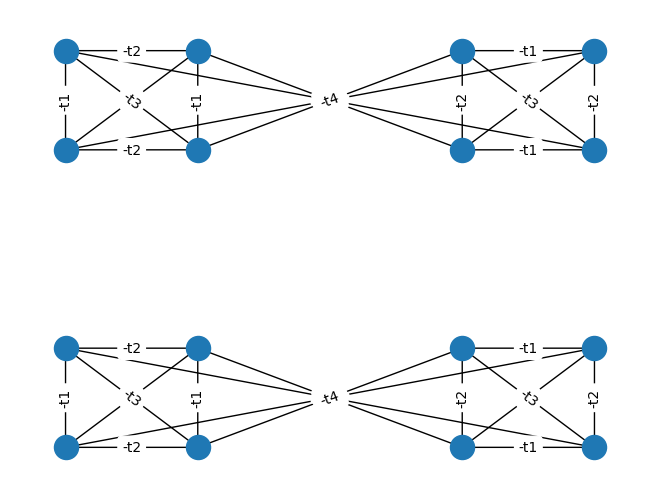

In [6]:
g_example = generate_two_orbital_nx(2,2)
pos = get_node_attributes(g_example, 'pos')
edge_labels = dict([((n1, n2), d['label']) for n1, n2, d in g_example.edges(data=True)]);
draw(g_example, pos)
draw_networkx_edge_labels(g_example,pos, edge_labels = edge_labels);

print(g_example.edges(data=True))

In [7]:
t1 = -1
t2 = 1.3
t3 = 0.85
t4 = 0.85
mu = 1
nx_to_two_orbital_hamiltonian(g_example, t1, t2, t3, t4, mu)

-1.0 [0^ 0] +
1.0 [0^ 4] +
-1.3 [0^ 8] +
-0.85 [0^ 12] +
0.85 [0^ 14] +
-1.0 [1^ 1] +
1.0 [1^ 5] +
-1.3 [1^ 9] +
-0.85 [1^ 13] +
0.85 [1^ 15] +
-1.0 [2^ 2] +
-1.3 [2^ 6] +
1.0 [2^ 10] +
0.85 [2^ 12] +
-0.85 [2^ 14] +
-1.0 [3^ 3] +
-1.3 [3^ 7] +
1.0 [3^ 11] +
0.85 [3^ 13] +
-0.85 [3^ 15] +
1.0 [4^ 0] +
-1.0 [4^ 4] +
-0.85 [4^ 8] +
-0.85 [4^ 10] +
-1.3 [4^ 12] +
1.0 [5^ 1] +
-1.0 [5^ 5] +
-0.85 [5^ 9] +
-0.85 [5^ 11] +
-1.3 [5^ 13] +
-1.3 [6^ 2] +
-1.0 [6^ 6] +
-0.85 [6^ 8] +
-0.85 [6^ 10] +
1.0 [6^ 14] +
-1.3 [7^ 3] +
-1.0 [7^ 7] +
-0.85 [7^ 9] +
-0.85 [7^ 11] +
1.0 [7^ 15] +
-1.3 [8^ 0] +
-0.85 [8^ 4] +
-0.85 [8^ 6] +
-1.0 [8^ 8] +
1.0 [8^ 12] +
-1.3 [9^ 1] +
-0.85 [9^ 5] +
-0.85 [9^ 7] +
-1.0 [9^ 9] +
1.0 [9^ 13] +
1.0 [10^ 2] +
-0.85 [10^ 4] +
-0.85 [10^ 6] +
-1.0 [10^ 10] +
-1.3 [10^ 14] +
1.0 [11^ 3] +
-0.85 [11^ 5] +
-0.85 [11^ 7] +
-1.0 [11^ 11] +
-1.3 [11^ 15] +
-0.85 [12^ 0] +
0.85 [12^ 2] +
-1.3 [12^ 4] +
1.0 [12^ 8] +
-1.0 [12^ 12] +
-0.85 [13^ 1] +
0.85 [13^ 3] +
-1.3 [13^ 5

In [8]:
g_current_limit = generate_two_orbital_nx(6,7)
g_ideal = generate_two_orbital_nx(20,20)

##### START UNCOMMENT FOR TESTING
n_test = 2
g_current_limit = generate_two_orbital_nx(n_test,n_test)  
g_ideal = generate_two_orbital_nx(n_test,n_test)
##### END UNCOMMENT FOR TESTING
n_qubits_current_limit = len(g_current_limit)
n_qubits_ideal = len(g_ideal)

Now that we have the Hamiltonians for both the model which constitutes the current limit of classical solvers, and the ideal capability of a solver, we can perform resource estimation for the Hamiltonians.  As with the single qubit model, we need to get a decent state initialization using Hartree-Fock.  As above, this has not been implemented at this time, but should have low depth in the quantum circuit since Hartree-Fock outputs a product state.

In [9]:
#TODO: Incorporate Hartree-Fock into this section to prepare the initial state for QPE for GSEE.
#This should provide a low depth initialization circuit relative to the depth of the QPE, while giving access to a low-energy subspace

Assuming that we have the output from the Hartree-Fock simulation, we may now perform QPE as above.  Currently we are using a short evolution time and a second order trotterization with a single step.  We will use scaling arguments to determine the final resources since generating the full circuit for a large number of trotter steps with many bits of precision is quite costly.

In [10]:
ham_current_limit = nx_to_two_orbital_hamiltonian(g_current_limit,t1,t2,t3,t4,mu)
ham_ideal = nx_to_two_orbital_hamiltonian(g_ideal,t1,t2,t3,t4,mu)
trotter_order_current_limit = 2
trotter_steps_current_limit = 1 #Using one trotter step for a strict lower bound with this method

trotter_order_ideal = 2
trotter_steps_ideal = 1 #Using one trotter step for a strict lower bound with this method

bits_precision_ideal = 16
bits_precision_current_limit = 16

E_min_ideal = -len(ham_ideal.terms)
E_max_ideal = 0
omega_ideal = E_max_ideal-E_min_ideal
t_ideal = 2*np.pi/omega_ideal
phase_offset_ideal = E_max_ideal*t_ideal

E_min_current_limit = -len(ham_current_limit.terms)
E_max_current_limit = 0
omega_current_limit = E_max_current_limit-E_min_current_limit
t_current_limit = 2*np.pi/omega_current_limit
phase_offset_current_limit = E_max_current_limit*t_current_limit

init_state_ideal = [0] * n_qubits_ideal
init_state_current_limit = [0] * n_qubits_current_limit

current_limit_args = {
    'trotterize' : True,
    'mol_ham'    : ham_current_limit,
    'ev_time'    : t_current_limit,
    'trot_ord'   : trotter_order_current_limit,
    'trot_num'   : 1
}

ideal_args = {
    'trotterize' : True,
    'mol_ham'    : ham_ideal,
    'ev_time'    : t_ideal,
    'trot_ord'   : trotter_order_ideal,
    'trot_num'   : 1
}

In [11]:
metadata_current_limit = EstimateMetaData(
    id=3000,
    name='FermiHubbard_Two_Band_Current_Limit`',
    category='scientific',
    size=f'{6}x{7}',
    task='Ground State Energy Estimation',
    implementations=f'GSEE, evolution_time={t_current_limit}, bits_precision={bits_precision_current_limit}, trotter_order={trotter_order_current_limit}',
)

metadata_ideal = EstimateMetaData(
    id=4000,
    name='FermiHubbard_Two_Band_Ideal',
    category='scientific',
    size=f'{20}x{20}',
    task='Ground State Energy Estimation',
    implementations=f'GSEE, evolution_time={t_ideal}, bits_precision={bits_precision_ideal}, trotter_order={trotter_order_ideal}',
)

In [12]:
print('Estimating Current Limit')
t0 = time.perf_counter()

estimate_current_limit = gsee_resource_estimation(
    outdir='GSE/FermiHubbard/',
    numsteps=trotter_steps_current_limit,
    gsee_args=current_limit_args,
    init_state=init_state_current_limit,
    precision_order=1,
    bits_precision=bits_precision_current_limit,
    phase_offset=phase_offset_current_limit,
    circuit_name='two_band_current_limit',
    metadata=metadata_current_limit,
    write_circuits=True
)
t1 = time.perf_counter()
print(f'Time to estimate Current Limit: {t1-t0}')

print('Estimating Ideal')
t0 = time.perf_counter()
estimate_ideal = gsee_resource_estimation(
    outdir='GSE/FermiHubbard/',
    numsteps=trotter_steps_ideal,
    gsee_args=ideal_args,
    init_state=init_state_ideal,
    precision_order=1,
    bits_precision=bits_precision_ideal,
    phase_offset=phase_offset_ideal,
    circuit_name='two_band_ideal',
    metadata=metadata_ideal,
    write_circuits=True
)
t1 = time.perf_counter()
print(f'Time to estimate Ideal: {t1-t0}')

Estimating Current Limit
Time to generate circuit for GSEE: 7.179100066423416e-05 seconds
   Time to decompose high level <class 'cirq.ops.common_gates.HPowGate circuit: 0.00017420900985598564 seconds 
   Time to transform decomposed <class 'cirq.ops.common_gates.HPowGate circuit to Clifford+T: 0.00020945898722857237 seconds
   Time to decompose high level <class 'cirq.ops.identity.IdentityGate circuit: 2.4416978703811765e-05 seconds 
   Time to transform decomposed <class 'cirq.ops.identity.IdentityGate circuit to Clifford+T: 5.54099096916616e-06 seconds
   Time to decompose high level <class 'pyLIQTR.PhaseEstimation.pe_gates.PhaseOffset circuit: 0.00010366700007580221 seconds 
   Time to transform decomposed <class 'pyLIQTR.PhaseEstimation.pe_gates.PhaseOffset circuit to Clifford+T: 0.00010866599041037261 seconds
   Time to decompose high level <class 'pyLIQTR.PhaseEstimation.pe_gates.Trotter_Unitary circuit: 0.24183270902722143 seconds 
   Time to transform decomposed <class 'pyLIQT

After Ground State Energy Estimation has been performed, we need to measure the autocorrelation, $\frac{1}{2}\langle \Delta_{i,j} + \Delta_{i,j}^{\dagger}\rangle$ where $\Delta_{i,j} = \langle c_{i+}c_{j-} - c_{i-}c_{j+} \rangle$.  As above, for the case where $i = j = 0$, this can be performed in the following way.  One can rotate into the Pauli basis using the following transformation, where for simplicity we assume that $i = j = 0$ is in the middle of the lattice.  We will label the qubit representing site $i+$ as qubit 1 and the qubit representing site $i-$ as qubit 2.  Given $U = CNOT_{i+,i-} H_{i+} CNOT_{i+,i-}$, it can be shown that $U^\dagger (c_{i+}c_{i-} - c_{i-}c_{i+}) U = -2 |\uparrow \uparrow \rangle \langle \uparrow \uparrow | + 2 |\downarrow \downarrow \rangle \langle \downarrow \downarrow|$.  This means that by simply applying the circuit $U$, then measuring, we can observe the autocorrelation.  This introduces 3 Clifford operations and no T gates.

A similar operation, though acting on 4 qubits rather than 2 qubits, can be achieved in a similarly low constant circuit depth for the case where $i \neq j$.

## Three Band

Lastly, we will demonstrate the same procedure for the three-band Fermi-Hubbard model, seen [here](http://sces.phys.utk.edu/publications/Pub2011/7-FOP-11107-ED.pdf). The Hamiltonian on a 2-d lattice is given by the sum of the following three Hamiltonians.  The first Hamiltonian, representing the hopping terms for the xz and yz orbitals, is the same as the two band Hamiltonian above:

\begin{equation}
\begin{split}
    H_{xz,yz} & = -t_1 \sum_{i,\sigma} \left( d^{\dagger}_{i,xz,\sigma}d_{i+\hat{y},xz,\sigma} +  d^{\dagger}_{i,yz,\sigma}d_{i+\hat{x}, yz, \sigma} + \text{h.c.} \right) \\
           & -t_2 \sum_{i,\sigma} \left( d^{\dagger}_{i,xz,\sigma}d_{i+\hat{x},xz,\sigma} +  d^{\dagger}_{i,yz,\sigma}d_{i+\hat{y}, yz, \sigma} + \text{h.c.} \right) \\
           & -t_3 \sum_{i,\hat{\mu}, \hat{\nu},\sigma} \left( d^{\dagger}_{i,xz,\sigma}d_{i+\hat{\mu} + \hat{\nu},xz,\sigma} +  d^{\dagger}_{i,yz,\sigma}d_{i+\hat{\mu} + \hat{\nu}, yz, \sigma} + \text{h.c.} \right) \\
           & +t_4 \sum_{i,\sigma} \left( d^{\dagger}_{i,xz,\sigma}d_{i+\hat{x}+\hat{y},yz,\sigma} +  d^{\dagger}_{i,yz,\sigma}d_{i+\hat{x}+\hat{y},xz,\sigma} + \text{h.c.} \right) \\
           & -t_4 \sum_{i,\sigma} \left( d^{\dagger}_{i,xz,\sigma}d_{i+\hat{x}-\hat{y},yz,\sigma} +  d^{\dagger}_{i,yz,\sigma}d_{i+\hat{x}-\hat{y},xz,\sigma} + \text{h.c.} \right) \\
           & -\mu \sum_{i} \left( n_{i}^{xz} + n_{i}^{yz} \right)
\end{split}
\end{equation}

The second Hamiltonian reflects the intra-orbital hopping terms for the $xy$ orbital is given by
\begin{equation}
\begin{split} H_{xy} &= t_5 \sum_{i,\hat{\mu}, \sigma} \left( d^{\dagger}_{i,xy,\sigma} d_{i+\hat{\mu},xy,\sigma} + \text{h.c.} \right) \\
           & -t_6 \sum_{i,\hat{\mu},\hat{\nu},\sigma} \left( d^{\dagger}_{i,xy,\sigma} d_{i+\hat{\mu}+\hat{\nu},xy,\sigma}  + \text{h.c.}\right) \\
           & + \Delta_{xy} \sum_{i} n_{i,xy} - \mu \sum_{i} n_{i,xy}
\end{split}
\end{equation}
The term $\Delta_{xy}$ represents the difference between the energy of the $xy$ and $xz$ or $yz$ orbitals.  Recall from the two band example above that the term $\hat{\mu}$ and $\hat{\nu}$ represent either the $\hat{x}$ or $\hat{y}$ unit vectors.  Therefore the summations over $\hat{\mu}$ represent nearest neighbor couplings.  

Finally, the third represents the hybridization terms between the $xy$ terms and the $xz$ or $yz$ terms.
\begin{equation}
\begin{split}
    H_{\text{xz,yz;xy}} &= -t_7 \sum_{i,\sigma} \left[ \left(-1\right)^{|{\bf{i}}|}d^{\dagger}_{{i},xz,\sigma} d_{{i} + \hat{x}, xy, \sigma} + \text{h.c.} \right]
                           -t_7 \sum_{i,\sigma} \left[ \left(-1\right)^{|{\bf{i}}|}d^{\dagger}_{{i},xy,\sigma} d_{{i} + \hat{x}, xz, \sigma} + \text{h.c.} \right] \\
                        &  -t_7 \sum_{i,\sigma} \left[ \left(-1\right)^{|{\bf{i}}|}d^{\dagger}_{{i},yz,\sigma} d_{{i} + \hat{y}, xy, \sigma} + \text{h.c.} \right]
                           -t_7 \sum_{i,\sigma} \left[ \left(-1\right)^{|{\bf{i}}|}d^{\dagger}_{{i},xy,\sigma} d_{{i} + \hat{y}, yz, \sigma} + \text{h.c.} \right] \\
                        &  -t_8 \sum_{i,\sigma} \left[ \left(-1\right)^{|{\bf{i}}|}d^{\dagger}_{{i},xz,\sigma} d_{{i} + \hat{x} + \hat{y}, xy, \sigma} + \text{h.c.} \right] 
                           +t_8 \sum_{i,\sigma} \left[ \left(-1\right)^{|{\bf{i}}|}d^{\dagger}_{{i},xy,\sigma} d_{{i} + \hat{x} + \hat{y}, xz, \sigma} + \text{h.c.} \right] \\
                        &  -t_8 \sum_{i,\sigma} \left[ \left(-1\right)^{|{\bf{i}}|}d^{\dagger}_{{i},xz,\sigma} d_{{i} + \hat{x} - \hat{y}, xy, \sigma} + \text{h.c.} \right] 
                           +t_8 \sum_{i,\sigma} \left[ \left(-1\right)^{|{\bf{i}}|}d^{\dagger}_{{i},xy,\sigma} d_{{i} + \hat{x} - \hat{y}, xz, \sigma} + \text{h.c.} \right] \\
                        &  -t_8 \sum_{i,\sigma} \left[ \left(-1\right)^{|{\bf{i}}|}d^{\dagger}_{{i},yz,\sigma} d_{{i} + \hat{x} + \hat{y}, xy, \sigma} + \text{h.c.} \right] 
                           +t_8 \sum_{i,\sigma} \left[ \left(-1\right)^{|{\bf{i}}|}d^{\dagger}_{{i},xy,\sigma} d_{{i} + \hat{x} + \hat{y}, yz, \sigma} + \text{h.c.} \right] \\
                        &  +t_8 \sum_{i,\sigma} \left[ \left(-1\right)^{|{\bf{i}}|}d^{\dagger}_{{i},yz,\sigma} d_{{i} + \hat{x} - \hat{y}, xy, \sigma} + \text{h.c.} \right] 
                           -t_8 \sum_{i,\sigma} \left[ \left(-1\right)^{|{\bf{i}}|}d^{\dagger}_{{i},xy,\sigma} d_{{i} + \hat{x} - \hat{y}, yz, \sigma} + \text{h.c.} \right] \\
\end{split}
\end{equation}

The terms $(-1)^{|\text{i}|}$ represent are site dependent parity terms that cause the sign of the interaction to depend on the site.  This comes from the two-iron unit cell of the FeAs planes in the material that these Hamiltonians are derived for.

The coefficients of the various terms are as follows:
$t_1 = 0.02$
, $t_2 = 0.06$
, $t_3 = 0.03$
, $t_4 = -0.01$
, $t_5 = 0.2$
, $t_6 = 0.3$
, $t_7 = -0.2$
, $t_8 = -t_7/2$
, $\Delta_{xy} = 0.4$

The value $\mu$ is swept and will be taken to be a representative value of 1 in this notebook.

[((0, 0, 0, 0), (0, 1, 0, 0), {'label': '-t1'}), ((0, 0, 0, 0), (1, 0, 0, 0), {'label': '-t2'}), ((0, 0, 0, 0), (1, 1, 0, 0), {'label': '-t3'}), ((0, 0, 0, 0), (1, 1, 1, 0), {'label': '+t4'}), ((0, 0, 0, 0), (1, 0, 2, 0), {'label': '-t7'}), ((0, 0, 0, 0), (1, 1, 2, 0), {'label': '-t8'}), ((0, 0, 0, 1), (0, 1, 0, 1), {'label': '-t1'}), ((0, 0, 0, 1), (1, 0, 0, 1), {'label': '-t2'}), ((0, 0, 0, 1), (1, 1, 0, 1), {'label': '-t3'}), ((0, 0, 0, 1), (1, 1, 1, 1), {'label': '+t4'}), ((0, 0, 0, 1), (1, 0, 2, 1), {'label': '-t7'}), ((0, 0, 0, 1), (1, 1, 2, 1), {'label': '-t8'}), ((0, 0, 1, 0), (1, 0, 1, 0), {'label': '-t1'}), ((0, 0, 1, 0), (0, 1, 1, 0), {'label': '-t2'}), ((0, 0, 1, 0), (1, 1, 1, 0), {'label': '-t3'}), ((0, 0, 1, 0), (1, 1, 0, 0), {'label': '+t4'}), ((0, 0, 1, 0), (0, 1, 2, 0), {'label': '-t7'}), ((0, 0, 1, 0), (1, 1, 2, 0), {'label': '-t8'}), ((0, 0, 1, 1), (1, 0, 1, 1), {'label': '-t1'}), ((0, 0, 1, 1), (0, 1, 1, 1), {'label': '-t2'}), ((0, 0, 1, 1), (1, 1, 1, 1), {'label': 

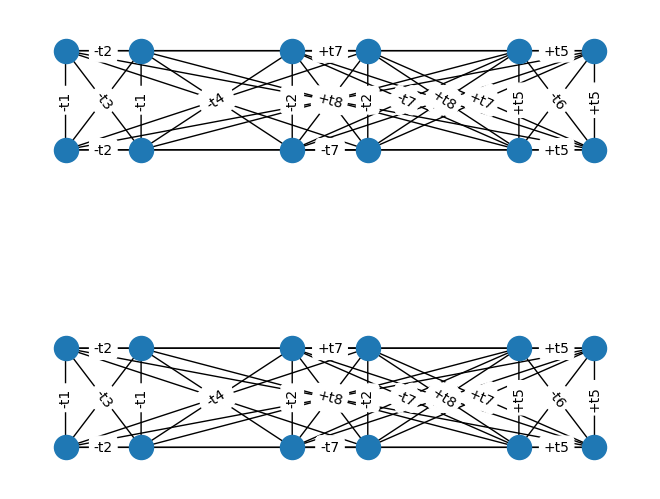

In [13]:
g_example = generate_three_orbital_nx(2,2)
pos = get_node_attributes(g_example, 'pos')
edge_labels = dict([((n1, n2), d['label']) for n1, n2, d in g_example.edges(data=True)]);
draw(g_example, pos)
draw_networkx_edge_labels(g_example,pos, edge_labels = edge_labels);

print(g_example.edges(data=True))

In [14]:
t1 = 0.02
t2 = 0.06
t3 = 0.03
t4 = -0.01
t5 = 0.2
t6 = 0.3
t7 = -0.2
t8 = -t7/2
mu = 1
delta = 0.4
nx_to_three_orbital_hamiltonian(g_example, t1, t2, t3, t4, t5, t6, t7, t8, mu, delta)

-1.0 [0^ 0] +
-0.02 [0^ 4] +
-0.06 [0^ 8] +
-0.03 [0^ 12] +
-0.01 [0^ 14] +
0.2 [0^ 20] +
-0.1 [0^ 22] +
-1.0 [1^ 1] +
-0.02 [1^ 5] +
-0.06 [1^ 9] +
-0.03 [1^ 13] +
-0.01 [1^ 15] +
0.2 [1^ 21] +
-0.1 [1^ 23] +
-1.0 [2^ 2] +
-0.06 [2^ 6] +
-0.02 [2^ 10] +
-0.01 [2^ 12] +
-0.03 [2^ 14] +
0.2 [2^ 18] +
-0.1 [2^ 22] +
-1.0 [3^ 3] +
-0.06 [3^ 7] +
-0.02 [3^ 11] +
-0.01 [3^ 13] +
-0.03 [3^ 15] +
0.2 [3^ 19] +
-0.1 [3^ 23] +
-0.02 [4^ 0] +
-1.0 [4^ 4] +
-0.03 [4^ 8] +
0.01 [4^ 10] +
-0.06 [4^ 12] +
0.1 [4^ 20] +
-0.2 [4^ 22] +
-0.02 [5^ 1] +
-1.0 [5^ 5] +
-0.03 [5^ 9] +
0.01 [5^ 11] +
-0.06 [5^ 13] +
0.1 [5^ 21] +
-0.2 [5^ 23] +
-0.06 [6^ 2] +
-1.0 [6^ 6] +
0.01 [6^ 8] +
-0.03 [6^ 10] +
-0.02 [6^ 14] +
0.2 [6^ 16] +
-0.1 [6^ 20] +
-0.06 [7^ 3] +
-1.0 [7^ 7] +
0.01 [7^ 9] +
-0.03 [7^ 11] +
-0.02 [7^ 15] +
0.2 [7^ 17] +
-0.1 [7^ 21] +
-0.06 [8^ 0] +
-0.03 [8^ 4] +
0.01 [8^ 6] +
-1.0 [8^ 8] +
-0.02 [8^ 12] +
0.2 [8^ 16] +
-0.1 [8^ 18] +
-0.06 [9^ 1] +
-0.03 [9^ 5] +
0.01 [9^ 7] +
-1.0 [9^ 9] +
-

In [15]:
g_current_limit = generate_three_orbital_nx(6,7)
g_ideal = generate_three_orbital_nx(20,20)

##### START UNCOMMENT FOR TESTING
n_test = 2
g_current_limit = generate_three_orbital_nx(n_test,n_test)  
g_ideal = generate_three_orbital_nx(n_test,n_test)
##### END UNCOMMENT FOR TESTING
n_qubits_current_limit = len(g_current_limit)
n_qubits_ideal = len(g_ideal)

Now that we have the Hamiltonians for both the model which constitutes the current limit of classical solvers, and the ideal capability of a solver, we can perform resource estimation for the Hamiltonians.  As with the single qubit model, we need to get a decent state initialization using Hartree-Fock.  As above, this has not been implemented at this time, but should have low depth in the quantum circuit since Hartree-Fock outputs a product state.

In [16]:
#TODO: Incorporate Hartree-Fock into this section to prepare the initial state for QPE for GSEE.
#This should provide a low depth initialization circuit relative to the depth of the QPE, while giving access to a low-energy subspace

Assuming that we have the output from the Hartree-Fock simulation, we may now perform QPE as above.  Currently we are using a short evolution time and a second order trotterization with a single step.  We will use scaling arguments to determine the final resources since generating the full circuit for a large number of trotter steps with many bits of precision is quite costly.

In [17]:
ham_current_limit = nx_to_three_orbital_hamiltonian(g_current_limit,t1,t2,t3,t4,t5,t6,t7,t8,mu,delta)
ham_ideal = nx_to_three_orbital_hamiltonian(g_ideal,t1,t2,t3,t4,t5,t6,t7,t8,mu,delta)
trotter_order_current_limit = 2
trotter_steps_current_limit = 1 #Using one trotter step for a strict lower bound with this method

trotter_order_ideal = 2
trotter_steps_ideal = 1 #Using one trotter step for a strict lower bound with this method

bits_precision_ideal = 16
bits_precision_current_limit = 16

E_min_ideal = -len(ham_ideal.terms)
E_max_ideal = 0
omega_ideal = E_max_ideal-E_min_ideal
t_ideal = 2*np.pi/omega_ideal
phase_offset_ideal = E_max_ideal*t_ideal

E_min_current_limit = -len(ham_current_limit.terms)
E_max_current_limit = 0
omega_current_limit = E_max_current_limit-E_min_current_limit
t_current_limit = 2*np.pi/omega_current_limit
phase_offset_current_limit = E_max_current_limit*t_current_limit

init_state_ideal = [0] * n_qubits_ideal
init_state_current_limit = [0] * n_qubits_current_limit

current_limit_args = {
    'trotterize' : True,
    'mol_ham'    : ham_current_limit,
    'ev_time'    : t_current_limit,
    'trot_ord'   : trotter_order_current_limit,
    'trot_num'   : 1
}

ideal_args = {
    'trotterize' : True,
    'mol_ham'    : ham_ideal,
    'ev_time'    : t_ideal,
    'trot_ord'   : trotter_order_ideal,
    'trot_num'   : 1
}

In [18]:
metadata_current_limit = EstimateMetaData(
    id=3000,
    name='FermiHubbard_ideal_Current_Limit`',
    category='scientific',
    size=f'{6}x{7}',
    task='Ground State Energy Estimation',
    implementations=f'GSEE, evolution_time={t_current_limit}, bits_precision={bits_precision_current_limit}, trotter_order={trotter_order_current_limit}',
)

metadata_ideal = EstimateMetaData(
    id=4000,
    name='FermiHubbard_ideal_Ideal',
    category='scientific',
    size=f'{20}x{20}',
    task='Ground State Energy Estimation',
    implementations=f'GSEE, evolution_time={t_ideal}, bits_precision={bits_precision_ideal}, trotter_order={trotter_order_ideal}',
)

In [19]:
print('Estimating Current Limit')
t0 = time.perf_counter()

estimate_current_limit = gsee_resource_estimation(
    outdir='GSE/FermiHubbard/',
    numsteps=trotter_steps_current_limit,
    gsee_args=current_limit_args,
    init_state=init_state_current_limit,
    precision_order=1,
    bits_precision=bits_precision_current_limit,
    phase_offset=phase_offset_current_limit,
    circuit_name='three_band_current_limit',
    metadata=metadata_current_limit,
    write_circuits=True
)
t1 = time.perf_counter()
print(f'Time to estimate Current Limit: {t1-t0}')

print('Estimating Ideal')
t0 = time.perf_counter()
estimate_ideal = gsee_resource_estimation(
    outdir='GSE/FermiHubbard/',
    numsteps=trotter_steps_ideal,
    gsee_args=ideal_args,
    init_state=init_state_ideal,
    precision_order=1,
    bits_precision=bits_precision_ideal,
    phase_offset=phase_offset_ideal,
    circuit_name='three_band_ideal',
    metadata=metadata_ideal,
    write_circuits=True
)
t1 = time.perf_counter()
print(f'Time to estimate Ideal: {t1-t0}')

Estimating Current Limit
Time to generate circuit for GSEE: 4.704200546257198e-05 seconds
   Time to decompose high level <class 'cirq.ops.common_gates.HPowGate circuit: 0.00011325001833029091 seconds 
   Time to transform decomposed <class 'cirq.ops.common_gates.HPowGate circuit to Clifford+T: 0.00022524999803863466 seconds
   Time to decompose high level <class 'cirq.ops.identity.IdentityGate circuit: 1.3165990822017193e-05 seconds 
   Time to transform decomposed <class 'cirq.ops.identity.IdentityGate circuit to Clifford+T: 3.4999975468963385e-06 seconds
   Time to decompose high level <class 'pyLIQTR.PhaseEstimation.pe_gates.PhaseOffset circuit: 8.550001075491309e-05 seconds 
   Time to transform decomposed <class 'pyLIQTR.PhaseEstimation.pe_gates.PhaseOffset circuit to Clifford+T: 9.033299284055829e-05 seconds
   Time to decompose high level <class 'pyLIQTR.PhaseEstimation.pe_gates.Trotter_Unitary circuit: 0.7486400830093771 seconds 
   Time to transform decomposed <class 'pyLIQTR

After Ground State Energy Estimation has been performed, we need to measure the autocorrelation, $\frac{1}{2}\langle \Delta_{i,j} + \Delta_{i,j}^{\dagger}\rangle$ where $\Delta_{i,j} = \langle c_{i+}c_{j-} - c_{i-}c_{j+} \rangle$.  As above, for the case where $i = j = 0$, this can be performed in the following way.  One can rotate into the Pauli basis using the following transformation, where for simplicity we assume that $i = j = 0$ is in the middle of the lattice.  We will label the qubit representing site $i+$ as qubit 1 and the qubit representing site $i-$ as qubit 2.  Given $U = CNOT_{i+,i-} H_{i+} CNOT_{i+,i-}$, it can be shown that $U^\dagger (c_{i+}c_{i-} - c_{i-}c_{i+}) U = -2 |\uparrow \uparrow \rangle \langle \uparrow \uparrow | + 2 |\downarrow \downarrow \rangle \langle \downarrow \downarrow|$.  This means that by simply applying the circuit $U$, then measuring, we can observe the autocorrelation.  This introduces 3 Clifford operations and no T gates.

A similar operation, though acting on 4 qubits rather than 2 qubits, can be achieved in a similarly low constant circuit depth for the case where $i \neq j$.